In [1]:
## Setup + data import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import itertools

#wikiData = pd.read_csv("../data/all_data/cleanWiki.csv")[["Article", "Language", "Month", "Count"]]
#wikiData_reverted = pd.read_csv("../data/all_data/cleanWiki_reverted.csv")[["Article", "Language", "Month", "Count"]]
#protections=pd.read_csv("../data/all_data/protections.csv")[['article', 'language', 'start', 'end']]
#protections['start'] = pd.to_datetime(protections['start'], format='mixed')
#protections['end'] = pd.to_datetime(protections['end'], format='mixed')


In [2]:
wikiData_US = pd.read_csv("../data/detailed_data/detailedEdits_2024-06-13-11-03.csv")
wikiData_US['topic'] = 'US_Civil_War'

wikiData_UA = pd.read_csv("../data/detailed_data/detailedEdits_2024-06-13-22-44.csv")
wikiData_UA['topic'] = 'Ukraine'

wikiData_IP = pd.read_csv("../data/detailed_data/detailedEdits_2024-06-14-11-41.csv")
wikiData_IP['topic'] = 'Israel/Palestine'


wikiData_all = pd.concat([wikiData_UA, wikiData_US, wikiData_IP])[['user', 'timestamp', 'size', 'reverted', 'reversion', 'topic', 'article', 'language', 'total_edits', 'article_edits']].drop_duplicates()
wikiData_all['ratio_edits'] = (wikiData_all['article_edits']/wikiData_all['total_edits']).replace(np.inf, 1.01)

wikiData_all['timestamp'] = pd.to_datetime(wikiData_all['timestamp'])
wikiData_all['month'] = wikiData_all['timestamp'].dt.month
wikiData_all['year'] = wikiData_all['timestamp'].dt.year



In [3]:
israel_palestine_articles = [
        "Nakba","Mandatory_Palestine","1948_Arab-Israeli_War","David_Ben-Gurion","Yasser_Arafat","Six-Day_War","Yom_Kippur_War","Hummus","Falafel","Shawarma","First_Intifada",
        "United_Nations_Partition_Plan_for_Palestine", "Intercommunal_conflict_in_Mandatory_Palestine", "Lehi_(militant_group)", "Irgun", "Ze'ev_Jabotinsky",
        "Haganah", "1947–1948_civil_war_in_Mandatory_Palestine", "1948_Arab–Israeli_War", "Yitzhak_Rabin", "Palmach", "Moshe_Dayan", "Jewish_exodus_from_the_Muslim_world", 
        "1936–1939_Arab_revolt_in_Palestine", "Amin_al-Husseini", "1948_Palestinian_expulsion_and_flight", "List_of_towns_and_villages_depopulated_during_the_1947–1949_Palestine_war", "Plan_Dalet", 
        "Abd_al-Qadir_al-Husayni", "1929_Hebron_massacre", "Causes_of_the_1948_Palestinian_expulsion_and_flight", "Deir_Yassin_massacre", "Menachem_Begin", "Kfar_Etzion_massacre", "Hebrew_language", 
        "Suez_Crisis", "Six-Day_War", "Egypt–Israel_peace_treaty", "Palestinian_Arabic", "Culture_of_Palestine", "Palestinian_cuisine", "Samih_al-Qasim", "Mahmoud_Darwish", "Origin_of_the_Palestinians"
]

print(len(israel_palestine_articles))

us_civil_war_articles = [
    "Ulysses_S._Grant","Sherman's_March_to_the_Sea","William_Tecumseh_Sherman","Union_Army","Confederate_States_Army","Robert_E._Lee","Joseph_E._Johnston","Alexander_H._Stephens","James_Longstreet",
    "United_Daughters_of_the_Confederacy","Army_of_Northern_Virginia","Jefferson_Davis","Origins_of_the_American_Civil_War","Confederate_States_of_America","Abraham_Lincoln","Battle_of_Gettysburg", 
    "Judah_P._Benjamin", "John_C._Breckinridge", "Joseph_Wheeler", "P._G._T._Beauregard", "Franklin_Buchanan", "Nathan_Bedford_Forrest", "Ku_Klux_Klan", "John_C._Frémont", "Joseph_Hooker", "George_Meade", 
    "Wilmington_massacre", "Red_Shirts_(United_States)", "United_Confederate_Veterans", "Confederate_History_Month", "Robert_E._Lee_Day", "Stonewall_Jackson", "Jim_Crow_laws", "John_Brown_(abolitionist)", 
    "William_Lloyd_Garrison", "Frederick_Douglass", "Thaddeus_Stevens", "Battle_of_the_Wilderness", "Battle_of_Antietam", "Reconstruction_era", "Emancipation_Proclamation", 
    "Thirteenth_Amendment_to_the_United_States_Constitution", "Slavery_in_the_United_States", "States'_rights", "Historiographic_issues_about_the_American_Civil_War"
]

print(len(us_civil_war_articles))


ukraine_articles = [
        "Kyiv","Kievan_Rus'","Stepan_Bandera","Bohdan_Khmelnytsky","Cossacks","Ukrainian_language","Holodomor","Borscht","Symon_Petliura",
        "Ukrainian_People's_Republic","Mykhailo_Hrushevsky","Nikolai_Gogol","Taras_Shevchenko","Ukrainian_literature","Ivan_Franko","Ukrainian_Insurgent_Army","Organisation_of_Ukrainian_Nationalists","Pierogi",
        "Kolach_(bread)", "Paska_(bread)", "Pampushka", "Syrniki", "Rusyns", "Vyshyvanka", "Ukrainian_Soviet_Socialist_Republic", "Pereiaslav_Agreement", "West_Ukrainian_People's_Republic", 
        "Massacres_of_Poles_in_Volhynia_and_Eastern_Galicia", "Orange_Revolution", "Ukrainian_War_of_Independence", "Principality_of_Kiev", "Kyiv_Pechersk_Lavra","Golden_Gate,_Kyiv", "Bakhchysarai_Palace", 
        "Khreshchatyk", "Kamianets-Podilskyi_Castle",  "Saint_Sophia_Cathedral,_Kyiv", "Kobzar", "Hryhorii_Skovoroda", "Lesya_Ukrainka", "Rus'_people", "Zaporozhian_Cossacks", "Khmelnytsky_Uprising"
]

print(len(ukraine_articles))


l = list(wikiData_all[(wikiData_all['language'] == 'ru')]['article'].drop_duplicates())
m = ukraine_articles
[item for item in m if item not in l]


44
45
43


['Holodomor']

In [4]:
wikiData_all[wikiData_all['reversion'] == 1].sort_values('timestamp').head(100)

,user,timestamp,size,reverted,reversion,topic,article,language,total_edits,article_edits,ratio_edits,month,year
92202,Triggerhippie4,2018-01-05 12:10:02,84050,0,1,Israel/Palestine,Hebrew_language,en,20341,43.0,0.002114,1,2018
12022,Karl.i.biased,2018-01-06 01:32:19,80177,0,1,Ukraine,Stepan_Bandera,en,1606,35.0,0.021793,1,2018
47159,Acroterion,2018-01-07 03:49:51,84121,0,1,US_Civil_War,James_Longstreet,en,226049,1.0,0.000004,1,2018
147032,Андрей Романенко,2018-01-07 14:55:57,107356,0,1,Ukraine,Ukrainian_People's_Republic,ru,118938,2.0,0.000017,1,2018
149906,Юрий Владимирович Л.,2018-01-07 17:16:16,189164,0,1,Ukraine,Nikolai_Gogol,ru,85745,2.0,0.000023,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180785,El C,2018-01-27 04:21:06,216191,0,1,US_Civil_War,Slavery_in_the_United_States,en,182979,17.0,0.000093,1,2018
173029,Wanderer777,2018-01-27 06:30:04,50227,0,1,Ukraine,Massacres_of_Poles_in_Volhynia_and_Eastern_Gal...,ru,40644,81.0,0.001993,1,2018
84767,Viiictorrr,2018-01-27 09:58:47,231316,0,1,Ukraine,Kievan_Rus',uk,15404,1.0,0.000065,1,2018
173028,Воевода,2018-01-27 12:34:38,50543,0,1,Ukraine,Massacres_of_Poles_in_Volhynia_and_Eastern_Gal...,ru,61285,14.0,0.000228,1,2018


In [5]:
wikiData_grouped = wikiData_all.groupby(['topic', 'article', 'language', 'year', 'month']).agg(
    edits = ('timestamp', 'size'),
    reverted_edits = ('reverted', 'sum'),
    reversions = ('reversion', 'sum'),
    mean_size = ('size', 'mean')
).reset_index()

first_edits = wikiData_all.groupby(['article', 'language'])['timestamp'].min().reset_index().rename(columns={'timestamp': 'first_edit'})

# Step 3: Merge the minimum mean_d back to the original grouped DataFrame
wikiData_grouped = wikiData_grouped.merge(first_edits, on=['article', 'language'])

wikiData_grouped


,topic,article,language,year,month,edits,reverted_edits,reversions,mean_size,first_edit
0,Israel/Palestine,1929_Hebron_massacre,ar,2007,7,6,0,0,725.833333,2007-07-19 13:55:39
1,Israel/Palestine,1929_Hebron_massacre,ar,2007,8,1,0,0,916.000000,2007-07-19 13:55:39
2,Israel/Palestine,1929_Hebron_massacre,ar,2007,10,5,0,0,4190.000000,2007-07-19 13:55:39
3,Israel/Palestine,1929_Hebron_massacre,ar,2007,12,2,0,0,5977.500000,2007-07-19 13:55:39
4,Israel/Palestine,1929_Hebron_massacre,ar,2008,1,1,0,0,5838.000000,2007-07-19 13:55:39
...,...,...,...,...,...,...,...,...,...,...
55614,Ukraine,Zaporozhian_Cossacks,uk,2022,3,2,0,0,20818.000000,2008-04-29 14:22:24
55615,Ukraine,Zaporozhian_Cossacks,uk,2023,3,1,0,0,20918.000000,2008-04-29 14:22:24
55616,Ukraine,Zaporozhian_Cossacks,uk,2023,4,1,0,0,20918.000000,2008-04-29 14:22:24
55617,Ukraine,Zaporozhian_Cossacks,uk,2023,8,1,0,0,21295.000000,2008-04-29 14:22:24


In [6]:
first_edits[first_edits['article'] == 'Slavery_in_the_United_States']

,article,language,first_edit
281,Slavery_in_the_United_States,de,2008-06-13 17:36:31
282,Slavery_in_the_United_States,en,2003-06-26 11:05:26


In [7]:
def insert_empty_intervals(df, oldest = datetime(2005,1,1)):


    articles = df['article'].unique()
    langs = df['language'].unique()
    years = df['year'].sort_values(ascending = True).unique()
    months = df['month'].sort_values(ascending = True).unique()

    cartesian_product = list(itertools.product(articles, langs, years, months))

    df_cartesian_product = pd.DataFrame(cartesian_product, columns=['article', 'language', 'year', 'month'])
    

    result_df = pd.merge(df_cartesian_product, df, how = 'left', on = ['article', 'language', 'year', 'month'])
    

    result_df = result_df.drop(columns = ['first_edit', 'topic'], errors='ignore')
    result_df = result_df.merge(first_edits, on=['article', 'language'], how='left')
    result_df = result_df.merge(df[['topic', 'article']].drop_duplicates(), on = 'article', how='left')
    
    print(result_df[(result_df['article'] == 'Slavery_in_the_United_States') & (result_df['language'] == 'de')])
    

    result_df['edits'] = result_df['edits'].fillna(0)
    result_df['reverted_edits'] = result_df['reverted_edits'].fillna(0)
    result_df['reversions'] = result_df['reversions'].fillna(0)

    result_df = result_df[result_df['year'] >= oldest.year]
    result_df = result_df[result_df['year'] >= result_df['first_edit'].dt.year]
    result_df = result_df[(result_df['year'] > result_df['first_edit'].dt.year) | (result_df['month'] >= result_df['first_edit'].dt.month)]

    grouped = result_df.groupby(['article', 'language']).agg(
        total_edits = ('edits', 'sum'),
        total_reversions = ('reversions', 'sum'),
        total_reverted = ('reverted_edits', 'sum')
    ).reset_index()

    result_df = pd.merge(result_df, grouped, on=['article', 'language'], how='left')

    grouped2 = result_df[(result_df['year'] > 2020) | ((result_df['year'] == 2020) & (result_df['month'] > 8))].groupby(['article', 'language']).agg(
        total_edits = ('edits', 'sum'),
        total_reversions = ('reversions', 'sum'),
        total_reverted = ('reverted_edits', 'sum')
    ).reset_index()

    result_df = pd.merge(result_df, grouped2, on=['article', 'language'], how='left', suffixes=['', '_after_aug2020'])
    result_df['date'] = pd.to_datetime(result_df[['year', 'month']].assign(day=1))



    return result_df[
        ['topic', 'article', 'language', 'date', 'edits', 'reverted_edits', 'reversions', 'mean_size', 'first_edit', 'total_edits', 'total_reversions', 'total_reverted', 'total_edits_after_aug2020', 'total_reversions_after_aug2020', 'total_reverted_after_aug2020']
    ].sort_values('date')

In [8]:
print(len(wikiData_grouped))

wikiData = insert_empty_intervals(wikiData_grouped)

print(len(wikiData))


55619
                             article language  year  month  edits  \
109728  Slavery_in_the_United_States       de  2001      1    NaN   
109729  Slavery_in_the_United_States       de  2001      2    NaN   
109730  Slavery_in_the_United_States       de  2001      3    NaN   
109731  Slavery_in_the_United_States       de  2001      4    NaN   
109732  Slavery_in_the_United_States       de  2001      5    NaN   
...                              ...      ...   ...    ...    ...   
110011  Slavery_in_the_United_States       de  2024      8    NaN   
110012  Slavery_in_the_United_States       de  2024      9    NaN   
110013  Slavery_in_the_United_States       de  2024     10    NaN   
110014  Slavery_in_the_United_States       de  2024     11    NaN   
110015  Slavery_in_the_United_States       de  2024     12    NaN   

        reverted_edits  reversions  mean_size          first_edit  \
109728             NaN         NaN        NaN 2008-06-13 17:36:31   
109729             NaN     

In [9]:
wikiData[(wikiData['date'].dt.year == 2008) & (wikiData['article'] == 'Slavery_in_the_United_States')].head(25)

,topic,article,language,date,edits,reverted_edits,reversions,mean_size,first_edit,total_edits,total_reversions,total_reverted,total_edits_after_aug2020,total_reversions_after_aug2020,total_reverted_after_aug2020
40271,US_Civil_War,Slavery_in_the_United_States,en,2008-01-01,104.0,0.0,0.0,79623.134615,2003-06-26 11:05:26,11083.0,235.0,98.0,1405.0,83.0,98.0
40272,US_Civil_War,Slavery_in_the_United_States,en,2008-02-01,132.0,0.0,0.0,87039.083333,2003-06-26 11:05:26,11083.0,235.0,98.0,1405.0,83.0,98.0
40273,US_Civil_War,Slavery_in_the_United_States,en,2008-03-01,137.0,0.0,0.0,87833.167883,2003-06-26 11:05:26,11083.0,235.0,98.0,1405.0,83.0,98.0
40274,US_Civil_War,Slavery_in_the_United_States,en,2008-04-01,128.0,0.0,0.0,86858.937500,2003-06-26 11:05:26,11083.0,235.0,98.0,1405.0,83.0,98.0
40275,US_Civil_War,Slavery_in_the_United_States,en,2008-05-01,159.0,0.0,0.0,86154.232704,2003-06-26 11:05:26,11083.0,235.0,98.0,1405.0,83.0,98.0
40276,US_Civil_War,Slavery_in_the_United_States,en,2008-06-01,54.0,0.0,0.0,92337.518519,2003-06-26 11:05:26,11083.0,235.0,98.0,1405.0,83.0,98.0
40036,US_Civil_War,Slavery_in_the_United_States,de,2008-06-01,1.0,0.0,0.0,2426.000000,2008-06-13 17:36:31,878.0,16.0,39.0,124.0,15.0,39.0
40277,US_Civil_War,Slavery_in_the_United_States,en,2008-07-01,48.0,0.0,0.0,103043.395833,2003-06-26 11:05:26,11083.0,235.0,98.0,1405.0,83.0,98.0
40037,US_Civil_War,Slavery_in_the_United_States,de,2008-07-01,7.0,0.0,0.0,10234.714286,2008-06-13 17:36:31,878.0,16.0,39.0,124.0,15.0,39.0
40278,US_Civil_War,Slavery_in_the_United_States,en,2008-08-01,26.0,0.0,0.0,105000.538462,2003-06-26 11:05:26,11083.0,235.0,98.0,1405.0,83.0,98.0


In [10]:
wikiData[wikiData['total_edits'] > 200][['article', 'language', 'total_edits']].sort_values('total_edits').drop_duplicates()

,article,language,total_edits
38294,Reconstruction_era,de,202.0
56682,Kolach_(bread),ru,203.0
10989,Irgun,ar,205.0
20440,Shawarma,de,208.0
37069,Nathan_Bedford_Forrest,de,209.0
...,...,...,...
29588,Confederate_States_of_America,en,10407.0
40309,Slavery_in_the_United_States,en,11083.0
36909,Ku_Klux_Klan,en,11679.0
25999,Abraham_Lincoln,en,17585.0


In [34]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def transform_count(article = None, lang = None, df = wikiData):

    if article is not None and lang is not None:
        filter_df = df[(df['article'] == article) & (df['language'] == lang)]
    else:
        filter_df = df

    edits = filter_df['edits']

    return (edits - edits.mean()) / edits.std()


     

def transform_counts(article1, lang1, article2, lang2, df = wikiData):

    filter_df_1 = df[(df['article'] == article1) & (df['language'] == lang1)]
    filter_df_2 = df[(df['article'] == article2) & (df['language'] == lang2)]

    filter_df_1 = filter_df_1[filter_df_1['date'].isin(filter_df_2['date'])]
    filter_df_2 = filter_df_2[filter_df_2['date'].isin(filter_df_1['date'])]

    series_1 = transform_count(df = filter_df_1)
    series_2 = transform_count(df = filter_df_2)
    
    return series_1, series_2

def correlation_edits(article1, lang1, article2, lang2, df = wikiData):

    series1, series2 = transform_counts(article1, lang1, article2, lang2, df)
    correlation, _ = pearsonr(series1, series2)
    
    return correlation, _

def plot_correlation(article1, lang1, article2, lang2, df = wikiData):
    
    series1, series2 = transform_counts(article1, lang1, article2, lang2, df)
    correlation, _ = pearsonr(series1, series2)
    print(pearsonr(series1, series2))

    plt.figure(figsize=(10, 6))
    plt.plot(df['date'].unique(), series1, label= "{} , {}".format(article1, lang1) , color='blue')
    plt.plot(df['date'].unique(), series2, label= "{} , {}".format(article2, lang2) , color='red')

    plt.xlabel('Date')
    plt.ylabel('Relative count of edits')
    plt.title('Pearson correlation: %.3f' % correlation)
    plt.legend()

    plt.show()
    

correlation_edits('Abraham_Lincoln', 'en', 'Abraham_Lincoln', 'de')[0]


0.34440226725219436

PearsonRResult(statistic=0.34440226725219436, pvalue=4.349307015948736e-08)


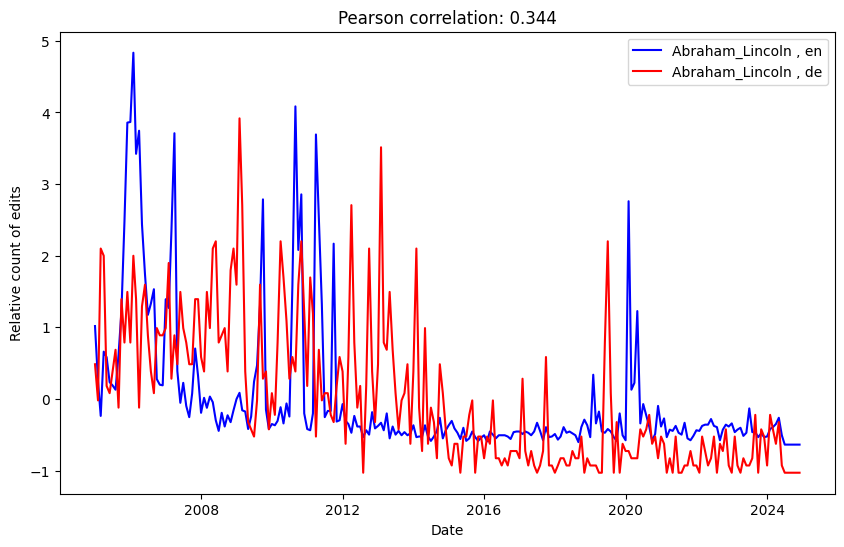

In [35]:
plot_correlation('Abraham_Lincoln', 'en', 'Abraham_Lincoln', 'de')

In [36]:
print(len(wikiData))

wikiData = wikiData[wikiData['total_edits'] > 0]

print(len(wikiData))

82656
82656


In [37]:
wikiData.loc[wikiData['total_edits'] > 200, ['article', 'language']].drop_duplicates()

,article,language
57115,Kyiv,en
24367,Yom_Kippur_War,ar
58074,Kyiv_Pechersk_Lavra,en
32121,James_Longstreet,en
69482,Rusyns,en
...,...,...
16491,Nakba,ar
11697,Jewish_exodus_from_the_Muslim_world,de
9228,Hebrew_language,ar
16887,Nakba,en


In [38]:
def calculate_correlations(df : pd.DataFrame = wikiData) -> pd.DataFrame:

    correlations = pd.DataFrame(columns=['Article1', 'Article2', 'Lang1', 'Lang2', 'Correlation', 'P_value'])
    
    df = df[df['total_edits'] > 0]

    unique_pairs = list(df.drop_duplicates(subset=['article', 'language'])[['article', 'language']].to_records(index=False))

    for c in itertools.combinations(unique_pairs, 2):
        
        try:
 
            correlation = correlation_edits(c[0][0], c[0][1], c[1][0], c[1][1])
            row = pd.DataFrame({'Article1': [c[0][0]], 'Article2' : [c[1][0]], 'Lang1' : [c[0][1]], 'Lang2' : [c[1][1]], 'Correlation' : [correlation[0]], 'P_value' : [correlation[1]]})
            correlations=pd.concat([correlations, row])
        except:
            continue

    return correlations

def join_topics(topics_df : pd.DataFrame, df : pd.DataFrame) -> pd.DataFrame:
    
    df = pd.merge(df, topics_df, 'left', left_on = 'Article1', right_on = 'Article')[['Article1', 'Article2', 'Lang1', 'Lang2', 'Correlation', 'P_value', 'Topic']]
    df = pd.merge(df, topics_df, 'left', left_on = 'Article2', right_on = 'Article', suffixes = ['_1', '_2'])[['Article1', 'Article2', 'Lang1', 'Lang2', 'Correlation', 'P_value', 'Topic_1', 'Topic_2']]

    return df

def determine_group(row):
    
    return_value = ''
    if row['Article1'] == row['Article2'] and row['Lang1'] != row['Lang2']:
        return 'Same Article'
    
    if row['Topic_1'] == row['Topic_2']:
        return_value += 'Same Topic'
        if row['Lang1'] == row['Lang2']:
            return_value += ', Same language '
            
    if return_value == '':
        return_value += 'Nothing common'

    return return_value


def assign_groups(df):

    df['Group'] = df.apply(determine_group, axis=1)
    return df

def correlations_topics_groups(df: pd.DataFrame, topics_df: pd.DataFrame):

    df_correlations = calculate_correlations(df)
    print("Correlations calculated")

    df_topics = join_topics(topics_df, df_correlations)
    print("Topics assigned")

    df_groups = assign_groups(df_topics)
    print("Groups assigned")

    df_groups = df_groups.sort_values('Correlation', ascending = False)
    
    return df_groups

In [39]:
topics = {
    'Ukraine' : 
    ["Kyiv","Kievan_Rus'","Stepan_Bandera","Bohdan_Khmelnytsky","Cossacks","Ukrainian_language","Holodomor","Borscht","Symon_Petliura",
    "Ukrainian_People's_Republic","Mykhailo_Hrushevsky","Nikolai_Gogol","Taras_Shevchenko","Ukrainian_literature","Ivan_Franko","Ukrainian_Insurgent_Army","Organisation_of_Ukrainian_Nationalists","Pierogi",
    "Kolach_(bread)", "Paska_(bread)", "Pampushka", "Syrniki", "Rusyns", "Vyshyvanka", "Ukrainian_Soviet_Socialist_Republic", "Pereiaslav_Agreement", "West_Ukrainian_People's_Republic", 
    "Massacres_of_Poles_in_Volhynia_and_Eastern_Galicia", "Orange_Revolution", "Ukrainian_War_of_Independence", "Principality_of_Kiev", "Kyiv_Pechersk_Lavra","Golden_Gate,_Kyiv", "Bakhchysarai_Palace", 
    "Khreshchatyk", "Kamianets-Podilskyi_Castle",  "Saint_Sophia_Cathedral,_Kyiv", "Kobzar", "Hryhorii_Skovoroda", "Lesya_Ukrainka", "Rus'_people", "Zaporozhian_Cossacks", "Khmelnytsky_Uprising"],

    'Israel/Palestine' : 
    ["Nakba","Mandatory_Palestine","1948_Arab-Israeli_War","David_Ben-Gurion","Yasser_Arafat","Six-Day_War","Yom_Kippur_War","Hummus","Falafel","Shawarma","First_Intifada",
     "United_Nations_Partition_Plan_for_Palestine", "Intercommunal_conflict_in_Mandatory_Palestine", "Lehi_(militant_group)", "Irgun", "Ze'ev_Jabotinsky",
     "Haganah", "1947–1948_civil_war_in_Mandatory_Palestine", "1948_Arab–Israeli_War", "Yitzhak_Rabin", "Palmach", "Moshe_Dayan", "Jewish_exodus_from_the_Muslim_world", 
     "1936–1939_Arab_revolt_in_Palestine", "Amin_al-Husseini", "1948_Palestinian_expulsion_and_flight", "List_of_towns_and_villages_depopulated_during_the_1947–1949_Palestine_war", "Plan_Dalet", 
     "Abd_al-Qadir_al-Husayni", "1929_Hebron_massacre", "Causes_of_the_1948_Palestinian_expulsion_and_flight", "Deir_Yassin_massacre", "Menachem_Begin", "Kfar_Etzion_massacre", "Hebrew_language", 
     "Suez_Crisis", "Six-Day_War", "Egypt–Israel_peace_treaty", "Palestinian_Arabic", "Culture_of_Palestine", "Palestinian_cuisine", "Samih_al-Qasim", "Mahmoud_Darwish", "Origin_of_the_Palestinians"],
    
    'Italian_Fascism' : 
    ["Benito_Mussolini","Fall_of_the_Fascist_regime_in_Italy","Italian_Social_Republic","Rodolfo_Graziani","Ardeatine_massacre","Sant%27Anna_di_Stazzema_massacre","Istrian-Dalmatian_exodus","Foibe_massacres"],
    
    'Expulsion_Germans' : 
    ["Flight_and_expulsion_of_Germans_(1944–1950)","Expulsion_of_Germans_from_Czechoslovakia","Ústí_massacre","Sudetenland","Brno_death_march","Beneš_decrees",
     "Sudetendeutsche_Landsmannschaft","German_Expellees","Recovered_Territories","Flight_and_expulsion_of_Germans_from_Poland_during_and_after_World_War_II","Oder-Neisse_line"],
    
    'US_Civil_War' : 
    ["Ulysses_S._Grant","Sherman's_March_to_the_Sea","William_Tecumseh_Sherman","Union_Army","Confederate_States_Army","Robert_E._Lee","Joseph_E._Johnston","Alexander_H._Stephens","James_Longstreet",
     "United_Daughters_of_the_Confederacy","Army_of_Northern_Virginia","Jefferson_Davis","Origins_of_the_American_Civil_War","Confederate_States_of_America","Abraham_Lincoln","Battle_of_Gettysburg", 
     "Judah_P._Benjamin", "John_C._Breckinridge", "Joseph_Wheeler", "P._G._T._Beauregard", "Franklin_Buchanan", "Nathan_Bedford_Forrest", "Ku_Klux_Klan", "John_C._Frémont", "Joseph_Hooker", "George_Meade", 
     "Wilmington_massacre", "Red_Shirts_(United_States)", "United_Confederate_Veterans", "Confederate_History_Month", "Robert_E._Lee_Day", "Stonewall_Jackson", "Jim_Crow_laws", "John_Brown_(abolitionist)", 
     "William_Lloyd_Garrison", "Frederick_Douglass", "Thaddeus_Stevens", "Battle_of_the_Wilderness", "Battle_of_Antietam", "Reconstruction_era", "Emancipation_Proclamation", 
     "Thirteenth_Amendment_to_the_United_States_Constitution", "Slavery_in_the_United_States", "States'_rights", "Historiographic_issues_about_the_American_Civil_War"],
     
     'Slovak_Fascism':
     ["Slovak_National_Uprising","Jozef_Tiso","Slovak_Republic_(1939-1945)","Slovak_People%27s_Party","Ján_Vojtaššák","Alexander_Mach","Andrej_Hlinka"]
}

topics_df = pd.DataFrame([(key, value) for key in topics for value in topics[key]], columns=['Topic', 'Article'])

topics_df

,Topic,Article
0,Ukraine,Kyiv
1,Ukraine,Kievan_Rus'
2,Ukraine,Stepan_Bandera
3,Ukraine,Bohdan_Khmelnytsky
4,Ukraine,Cossacks
...,...,...
153,Slovak_Fascism,Slovak_Republic_(1939-1945)
154,Slovak_Fascism,Slovak_People%27s_Party
155,Slovak_Fascism,Ján_Vojtaššák
156,Slovak_Fascism,Alexander_Mach


In [40]:
reversion_correlations = correlations_topics_groups(wikiData[(wikiData['total_edits'] > 500) & (wikiData['date'] >= datetime(2011,1,1))], topics_df)


Correlations calculated
Topics assigned
Groups assigned


In [41]:
def summarise_correlations(df):

    print(df['Group'].value_counts(normalize=True).reset_index())
    print("\n #### \n")
    print(df[df['Correlation'] > 0.3]['Group'].value_counts(normalize=True).reset_index())
    

In [42]:
summarise_correlations(reversion_correlations)
reversion_correlations.head(10)


                        Group  proportion
0              Nothing common    0.645187
1                  Same Topic    0.214405
2  Same Topic, Same language     0.133412
3                Same Article    0.006996

 #### 

                        Group  proportion
0              Nothing common    0.525074
1  Same Topic, Same language     0.325959
2                  Same Topic    0.132006
3                Same Article    0.016962


,Article1,Article2,Lang1,Lang2,Correlation,P_value,Topic_1,Topic_2,Group
19733,1948_Palestinian_expulsion_and_flight,1948_Palestinian_expulsion_and_flight,en,de,0.978904,3.780667e-166,Israel/Palestine,Israel/Palestine,Same Article
17144,Palestinian_cuisine,Palestinian_cuisine,en,de,0.974113,1.378285e-137,Israel/Palestine,Israel/Palestine,Same Article
12601,Mahmoud_Darwish,Mahmoud_Darwish,ar,en,0.794154,3.550392e-53,Israel/Palestine,Israel/Palestine,Same Article
16729,United_Nations_Partition_Plan_for_Palestine,Nakba,en,en,0.751854,2.635310e-09,Israel/Palestine,Israel/Palestine,"Same Topic, Same language"
19440,Battle_of_Antietam,Sherman's_March_to_the_Sea,en,en,0.736599,2.643186e-42,US_Civil_War,US_Civil_War,"Same Topic, Same language"
434,Yitzhak_Rabin,1947–1948_civil_war_in_Mandatory_Palestine,de,en,0.732628,4.137772e-37,Israel/Palestine,Israel/Palestine,Same Topic
17773,Joseph_Hooker,Battle_of_Antietam,en,en,0.724619,2.344908e-40,US_Civil_War,US_Civil_War,"Same Topic, Same language"
1947,Stonewall_Jackson,Robert_E._Lee,en,en,0.723685,3.293085e-40,US_Civil_War,US_Civil_War,"Same Topic, Same language"
1927,Stonewall_Jackson,Sherman's_March_to_the_Sea,en,en,0.723084,4.094624e-40,US_Civil_War,US_Civil_War,"Same Topic, Same language"
2534,First_Intifada,Nakba,en,en,0.716656,3.083912e-08,Israel/Palestine,Israel/Palestine,"Same Topic, Same language"


In [43]:
edit_correlations = correlations_topics_groups(wikiData[wikiData['total_edits'] > 200  & (wikiData['date'] >= datetime(2011,1,1))], topics_df)
all_edits_correlations = correlations_topics_groups(wikiData, topics_df)

Correlations calculated
Topics assigned
Groups assigned
Correlations calculated
Topics assigned
Groups assigned


In [21]:
summarise_correlations(edit_correlations)
edit_correlations.head(10)

                        Group  proportion
0              Nothing common    0.657469
1                  Same Topic    0.174859
2  Same Topic, Same language     0.160103
3                Same Article    0.007569

 #### 

                        Group  proportion
0              Nothing common    0.535749
1  Same Topic, Same language     0.361410
2                  Same Topic    0.089128
3                Same Article    0.013712


,Article1,Article2,Lang1,Lang2,Correlation,P_value,Topic_1,Topic_2,Group
4678,1948_Palestinian_expulsion_and_flight,1948_Palestinian_expulsion_and_flight,en,de,0.978904,3.780667e-166,Israel/Palestine,Israel/Palestine,Same Article
8519,Mahmoud_Darwish,Mahmoud_Darwish,ar,en,0.794154,3.550392e-53,Israel/Palestine,Israel/Palestine,Same Article
10059,United_Nations_Partition_Plan_for_Palestine,Nakba,en,en,0.751854,2.635310e-09,Israel/Palestine,Israel/Palestine,"Same Topic, Same language"
6548,Sherman's_March_to_the_Sea,Battle_of_Antietam,en,en,0.736599,2.643186e-42,US_Civil_War,US_Civil_War,"Same Topic, Same language"
6005,Joseph_Hooker,Battle_of_Antietam,en,en,0.724619,2.344908e-40,US_Civil_War,US_Civil_War,"Same Topic, Same language"
6898,Robert_E._Lee,Stonewall_Jackson,en,en,0.723685,3.293085e-40,US_Civil_War,US_Civil_War,"Same Topic, Same language"
6556,Sherman's_March_to_the_Sea,Stonewall_Jackson,en,en,0.723084,4.094624e-40,US_Civil_War,US_Civil_War,"Same Topic, Same language"
7809,First_Intifada,Nakba,en,en,0.716656,3.083912e-08,Israel/Palestine,Israel/Palestine,"Same Topic, Same language"
1731,Reconstruction_era,Battle_of_Antietam,en,en,0.715705,5.675659e-39,US_Civil_War,US_Civil_War,"Same Topic, Same language"
5978,Joseph_Hooker,Sherman's_March_to_the_Sea,en,en,0.684737,1.496560e-34,US_Civil_War,US_Civil_War,"Same Topic, Same language"


In [22]:
print(edit_correlations[['Topic_1', 'Topic_2']].value_counts(normalize=True).reset_index())

            Topic_1           Topic_2  proportion
0           Ukraine           Ukraine    0.181182
1  Israel/Palestine           Ukraine    0.143624
2      US_Civil_War           Ukraine    0.139695
3           Ukraine  Israel/Palestine    0.117754
4           Ukraine      US_Civil_War    0.091980
5  Israel/Palestine  Israel/Palestine    0.090352
6      US_Civil_War  Israel/Palestine    0.087956
7  Israel/Palestine      US_Civil_War    0.076459
8      US_Civil_War      US_Civil_War    0.070997


In [23]:
print(edit_correlations[edit_correlations['Correlation'] > 0.3][['Topic_1', 'Topic_2']].value_counts(normalize=True).reset_index())

            Topic_1           Topic_2  proportion
0  Israel/Palestine  Israel/Palestine    0.236043
1  Israel/Palestine      US_Civil_War    0.214496
2      US_Civil_War      US_Civil_War    0.193928
3      US_Civil_War  Israel/Palestine    0.126347
4           Ukraine  Israel/Palestine    0.057786
5      US_Civil_War           Ukraine    0.052889
6  Israel/Palestine           Ukraine    0.046033
7           Ukraine      US_Civil_War    0.038198
8           Ukraine           Ukraine    0.034280


In [54]:
import matplotlib.pyplot as plt

def calculate_intervals(article : str, lang : str, timestart : datetime = None, timestop : datetime = None, edits_df : pd.DataFrame = wikiData_all):

    # get relevant data
    
    filtered_df = edits_df[(edits_df['article'] == article) & (edits_df['language'] == lang)]

    if timestart is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] >= timestart]
    if timestop is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] <= timestop]

    filtered_df = filtered_df.sort_values('timestamp')

    intervals = filtered_df['timestamp'].diff().dt.total_seconds() / 3600 # convert difference to float representing hours
    
    return intervals[1:] #first value is always NaN

def burstiness(article : str, lang : str, timestart : datetime = None, timestop : datetime = None, edits_df : pd.DataFrame = wikiData_all):

    intervals = calculate_intervals(article, lang, timestart, timestop, edits_df)

    mean_interval = intervals.mean()
    std_interval = intervals.std()

    return (std_interval - mean_interval) / (std_interval + mean_interval)

def alt_burstiness(article : str, lang : str, timestart : datetime = None, timestop : datetime = None, edits_df : pd.DataFrame = wikiData_all):

    intervals = calculate_intervals(article, lang, timestart, timestop, edits_df)
    mean_interval = intervals.mean()
    median_interval = intervals.median()

    return mean_interval / median_interval


In [55]:
unique_articles = wikiData_all.groupby(['article', 'language', 'topic'])['timestamp'].min().reset_index()

unique_articles['edit_frequency'] = 0
unique_articles['edit_frequency_2010'] = 0
unique_articles['burstiness'] = 0
unique_articles['burstiness_2010'] = 0
unique_articles['alt_burstiness'] = 0
unique_articles['alt_burstiness_2010'] = 0

for index, row in unique_articles.iterrows():
    
    unique_articles.at[index, 'edit_frequency'] = calculate_intervals(row['article'], row['language']).mean()
    unique_articles.at[index, 'edit_frequency_2010'] = calculate_intervals(row['article'], row['language'], datetime(2010,1,1)).mean()
    unique_articles.at[index, 'burstiness'] = burstiness(row['article'], row['language'])
    unique_articles.at[index, 'burstiness_2010'] = burstiness(row['article'], row['language'], datetime(2010,1,1))
    unique_articles.at[index, 'alt_burstiness'] = alt_burstiness(row['article'], row['language'])
    unique_articles.at[index, 'alt_burstiness_2010'] = alt_burstiness(row['article'], row['language'], datetime(2010,1,1))

unique_articles

,article,language,topic,timestamp,edit_frequency,edit_frequency_2010,burstiness,burstiness_2010,alt_burstiness,alt_burstiness_2010
0,1929_Hebron_massacre,ar,Israel/Palestine,2007-07-19 13:55:39,1129.622605,1443.275685,0.213896,0.155639,4.020828,2.888993
1,1929_Hebron_massacre,de,Israel/Palestine,2009-07-03 07:57:54,1546.821155,1995.958333,0.172476,0.082215,3.547414,1.790636
2,1929_Hebron_massacre,en,Israel/Palestine,2006-08-09 21:43:48,133.639107,223.396681,0.412398,0.310385,43.828076,24.887529
3,1936–1939_Arab_revolt_in_Palestine,ar,Israel/Palestine,2007-07-17 18:46:35,327.553763,325.475171,0.318014,0.313324,8.966808,11.455575
4,1936–1939_Arab_revolt_in_Palestine,de,Israel/Palestine,2005-02-04 18:53:33,559.758995,645.476246,0.380841,0.359117,29.602521,138.287528
...,...,...,...,...,...,...,...,...,...,...
366,Zaporozhian_Cossacks,ru,Ukraine,2006-03-24 20:50:58,368.914729,264.764682,0.716322,0.337517,51.791640,37.460810
367,Zaporozhian_Cossacks,uk,Ukraine,2008-04-29 14:22:24,1396.998651,1142.961163,0.492293,0.481138,26.268700,35.287016
368,Ze'ev_Jabotinsky,ar,Israel/Palestine,2008-02-16 12:07:23,1071.865695,1114.750588,0.179028,0.180364,2.133703,2.057125
369,Ze'ev_Jabotinsky,de,Israel/Palestine,2006-05-01 15:43:46,839.555373,504.963518,0.699093,0.325068,33.164708,19.947425


In [93]:
unique_articles = unique_articles.merge(wikiData[['topic', 'article', 'language', 'total_edits']].drop_duplicates(), how='left', on=['topic', 'article', 'language'])

In [114]:
def plot_burstiness(article : str, lang : str, timestart : datetime = None, timestop : datetime = None, edits_df : pd.DataFrame = wikiData_all):

    filtered_df = edits_df[(edits_df['article'] == article) & (edits_df['language'] == lang)]

    if timestart is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] >= timestart]
    if timestop is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] <= timestop]

    filtered_df = filtered_df.sort_values('timestamp')

    plt.figure(figsize=(10, 6))

    for index, row in filtered_df.iterrows():
        plt.axvline(x=row['timestamp'], color='black', linestyle='-', alpha=0.7, linewidth = 0.4)
        

    plt.xlabel('Timestamp')
    plt.grid(True)
    plt.tight_layout()

    plt.show()


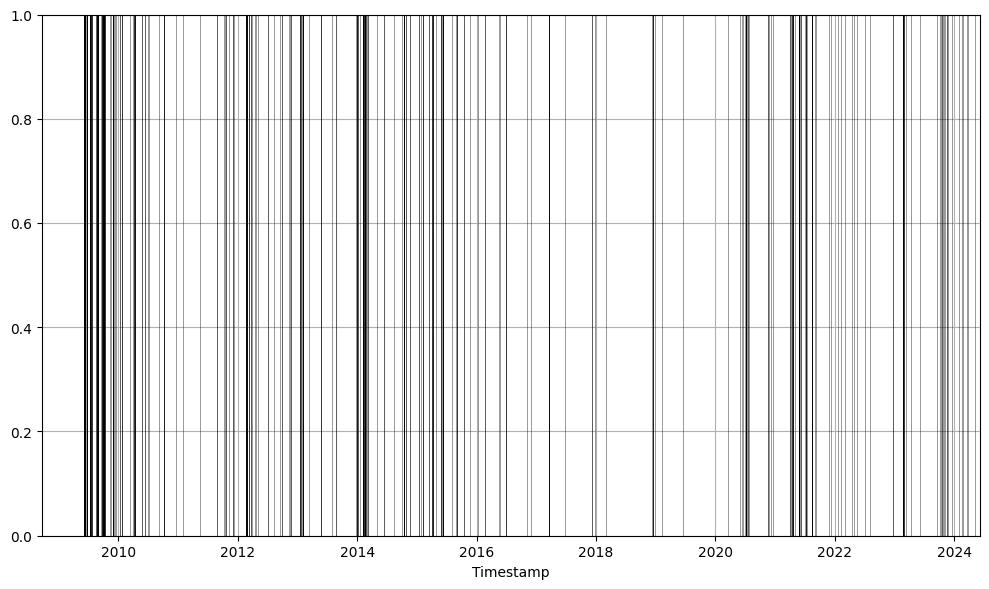

In [122]:
plot_burstiness('List_of_towns_and_villages_depopulated_during_the_1947–1949_Palestine_war', 'en')

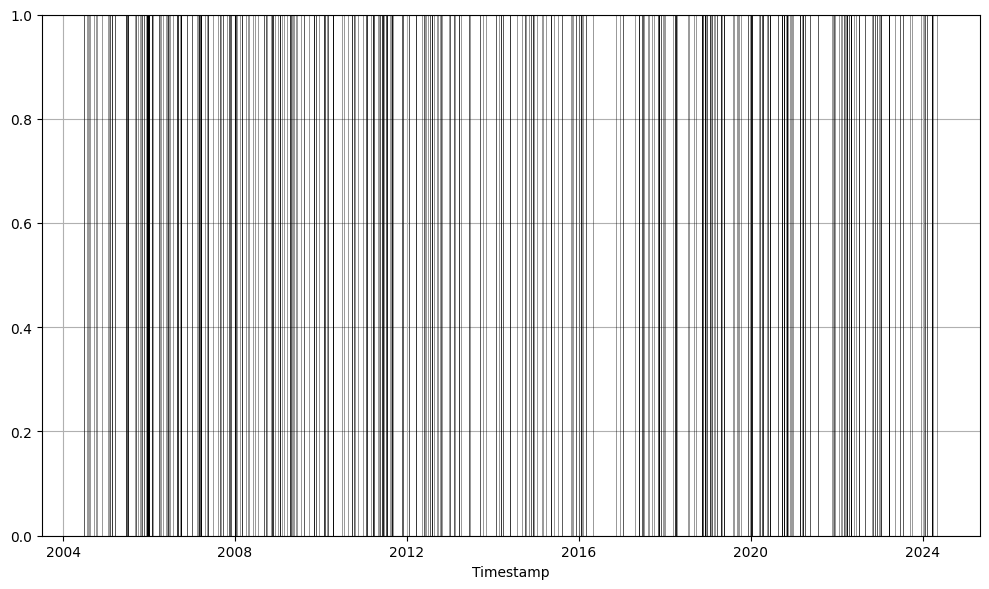

In [121]:
plot_burstiness('Saint_Sophia_Cathedral,_Kyiv', 'en')

In [50]:
unique_articles.groupby(['topic', 'language']).agg(
    frequency = ('edit_frequency', 'mean'),
    frequency_2010 = ('edit_frequency_2010', 'mean'),
    burstiness = ('burstiness', 'mean'),
    burstiness_2010 = ('burstiness_2010', 'mean')
).reset_index()


,topic,language,frequency,frequency_2010,burstiness,burstiness_2010
0,Israel/Palestine,ar,599.016678,645.128785,0.295760,0.272465
1,Israel/Palestine,de,662.262451,874.463337,0.352643,0.296928
2,Israel/Palestine,en,435.442203,180.749252,0.453299,0.381181
3,US_Civil_War,de,833.954305,1368.371457,0.356318,0.284516
4,US_Civil_War,en,139.738768,149.773181,0.474783,0.386372
5,Ukraine,de,962.723943,1064.635080,0.310081,0.300229
6,Ukraine,en,277.703935,283.579865,0.373297,0.331592
7,Ukraine,ru,252.140286,257.207716,0.400488,0.374442
8,Ukraine,uk,462.342167,452.813793,0.350066,0.344590
